<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/Project/MA_Team1_ProjectReport_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Report - Team 1

###**Task:** How to automatically update the ontology? 

Team members: 
- Johana Estrada (777211902958)
- Philipp Heitmann (77211890824)
- Minh Anh Hoang (77211887950)
- Theresa Ewert (77210570462)

<br>
Text Web Social Media Analytics Lab SS2022<br>
Prof. Dr. Markus Löcher <br>
Program: Business Intelligence & Process Management<br>
HWR Berlin

##### Install missing packages and imports

In [2]:
# Install missing dependencies
!pip install duckdb -q
!pip install -U sentence-transformers -q

     |████████████████████████████████| 15.7 MB 4.2 MB/s 
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 4.4 MB 32.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.6 MB/s 
     |████████████████████████████████| 101 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 28.0 MB/s 


In [3]:
# Import all packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import duckdb
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, TripletEvaluator, LabelAccuracyEvaluator

In order to be able to run our notebook you need to mount the notebook to the drive directory of the project `2022_Analytics Lab Student Projects`.

Please note that apart from the common `data` directory which includes the data from the ontology, sentences etc. we also created a separate folder `Data_Team1` which contain our modeling/ intermediate results

In [4]:
# Mount drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#set data paths
data_path = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/All Topics" #to access provided data from ontoogy etc.
data_path_group = data_path[:-10]+"Topic 1/Data_Team1/" #to access files created by Team1

## Introduction


## Ideal architecture

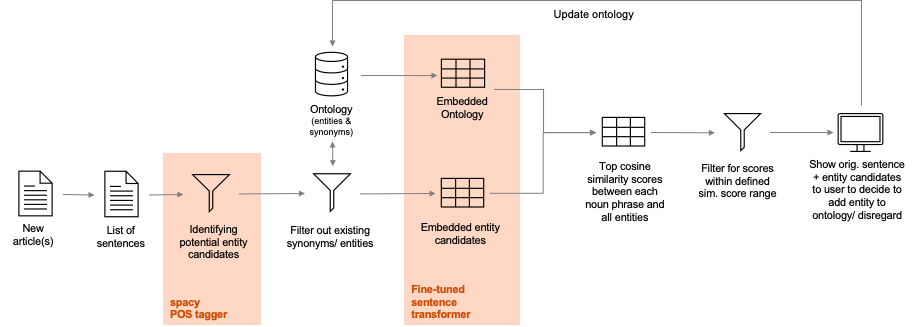

### spaCy & noun phrase extraction

### Entities & Synonyms

### Similarity comparison and filtering results for user

## Model selection and finetuning

So now that you have seen our main idea on how to solve this tasks and the complications we faced there, we are now at the point on where we want to make sure that our model embeddings are up to the task of identifying:

1. Synonyms of already existing entities and 
2. New entities which are not present in the ontology yet

Ideally the model embeddings should put the entites & corresponding synonyms close to each other, while maintaining a certain distance to other entities.

Additionally for NER, the child entity should also be located close to the correct "parent" entity

In order to let the model learn these relationships we created different training datasets, which we then used to further fine tune our model before we evaluate it on the "original" task. (See picture below)

-------------

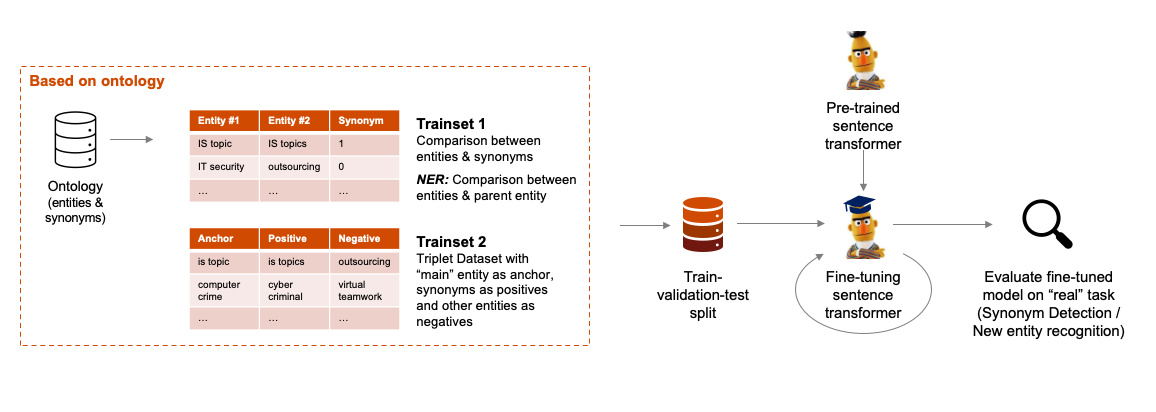

> ❗ Please note that the order shown in the above picture is not identical to our procedure in the project. As the train-validattion-test split of the ontology was the harder task, we created the train-validation-test first and then created the dataset. In order to replay our code completely you would need to execute the following notebooks in the correct order:
1. BLOCKER
2. BLOCKER
3. BLOCKER

### Create training datasets for finetuning the model on the ontology

In order to let the model learn these relationships/ similarities, we created two different training datasets for finetuning, which are based on the current ontology:

1. **Trainset 1 ("Synonym Dataset")**
  - Classification of true/ false entities/synonym pairs 
  - For NER we additonally created an additional version of this dataset to classify entity and parent entity pairs

2. **Trainset 2 ("Triplets Dataset")**
  - This trainingset is inspired by the Sentence-BERT paper
  - The triplets dataset consists of an 
    - **Anchor phrase** --> an entity from the ontology, 
    - **Positive example** --> synonym of the anchor and
    - **Negative example** --> another entity from the same "area" of the ontology
  - The training goal is that the model puts the positive example closer to the anchor than the negative example. 

<br>

>❗ Please note that we created two versions of each dataset. One for synonym detection and one for NER. In order to limit the size of the notebook we will only include the creation of one dataset each (NER). The code for the remaining ones can be found in the corresponding notebook(s) mentioned below.


For further details please see notebook: `NOTEBOOK NAME HERE`

#### Synonyms Dataset

- For the Synonym Datatset we create a dataset which include all true synonyms from the ontology as well as negative examples. 
- For the negative examples we randomly draw 100 other entity id from the training set which do not belong to this entity, but are in the same `category` (to ensure some more or less meaningful relation)

##### Load data

In [6]:
# Load train-val-test splits of entities/noun phrases
NER_entities_train_df = pd.read_csv(data_path_group+"NER/NER_entities_train.csv", index_col=0)
NER_entities_val_df = pd.read_csv(data_path_group+"NER/NER_entities_val.csv", index_col=0)
NER_entities_test_df = pd.read_csv(data_path_group+"NER/NER_entities_test.csv", index_col=0)

In [7]:
NER_entities_train_df.sample(1)

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
3142963,4854,4854_12923_12965,systems development,ambidexterity,0


In [8]:
# Load train-val-test splits of ontology
NER_ontology_train_df = pd.read_csv(data_path_group+"NER/NER_ontology_train.csv", index_col=0)
NER_ontology_val_df = pd.read_csv(data_path_group+"NER/NER_ontology_val.csv", index_col=0)
NER_ontology_test_df = pd.read_csv(data_path_group+"NER/NER_ontology_test.csv", index_col=0)

In [9]:
NER_ontology_train_df.sample(1)

,entity_id,category,label,synonym
220374,individual participant,study object,PARTICIPANTS,IS and knowledge knowledge bidder


##### Create functions to create dataset

In [10]:
def rand_sample_false_syn(x, ontology_df):
  ''' Create false synonym samples for synonyms dataset'''

  try:
      return np.random.choice(ontology_df[
                              (ontology_df.category==x.category)&
                              (ontology_df.entity_id!=x.entity_id)
                              ]
                          .entity_id.unique(),100, replace=True)    
  
  except:
      return np.random.choice(ontology_df[
                      #(ontology_df.category==x.category)&
                      (ontology_df.entity_id!=x.entity_id)
                      ]
                  .entity_id.unique(),100, replace=True)    

In [11]:
def create_synonyms_dataset(ontology_df, return_false_syn=True):
    '''Create synonyms dataset (positive and negative examples) '''

    #Filter out identical rows (main entity and synonym is the same word/phrase)
    ontology_df = ontology_df.loc[ontology_df.entity_id!=ontology_df.synonym]

    # Add new column to label whether entity_id and synonym are indeed synonmys
    ontology_df["is_synonym"] = 1

    ontology_false_synonyms_df = ontology_df[["entity_id", "category", "label"]].drop_duplicates("entity_id")

    ontology_false_synonyms_df["synonym"] = ontology_false_synonyms_df.apply(
                                        lambda x: rand_sample_false_syn(x,ontology_df), axis=1)

    ontology_false_synonyms_df["is_synonym"]=0
    ontology_false_synonyms_df = ontology_false_synonyms_df.explode("synonym")

    # Drop duplicates (because we draw with replacement)
    ontology_false_synonyms_df = ontology_false_synonyms_df.drop_duplicates()

    ontology_df = pd.concat([ontology_df, ontology_false_synonyms_df], axis=0).reset_index(drop=True).sample(frac=1)

    if return_false_syn==False:
        return ontology_df

    return ontology_df, ontology_false_synonyms_df

In [12]:
## Create datasets
#NER_ontology_train_df_syn, ontology_false_syn_train_df = create_synonyms_dataset(NER_ontology_train_df)
#NER_ontology_val_df_syn, ontology_false_syn_val_df = create_synonyms_dataset(NER_ontology_val_df)
#NER_ontology_test_df_syn, ontology_false_syn_test_df = create_synonyms_dataset(NER_ontology_test_df)

In [13]:
# Load dataset to show result
NER_ontology_train_df_syn = pd.read_csv(data_path_group+"NER/Synonym_Dataset/NER_ontology_train_df_syn.csv", index_col=0)
NER_ontology_train_df_syn.head(1)

,entity_id,category,label,synonym,is_synonym
533794,smart contract,domain specific entity,TECHNOLOGY,intelligent process automation,0


#### Triplets Dataset

- For the Triplets Datatset we set the "main" entity as the anchor, synonyms as positive and other entities from the same `categroy` as negative examples
- We reuse some of the code/ output from the synonym dataset

##### Create functions to create dataset

In [14]:
def create_triplets_dataset(ontology_df, ontology_false_syn_df):
    ''' Create triplets dataset'''

    ontology_triplets_df = ontology_df.merge(ontology_false_syn_df, how="inner", on="entity_id")

    ontology_triplets_df = ontology_triplets_df.loc[ontology_triplets_df.is_synonym_x==1]

    ontology_triplets_df = ontology_triplets_df.sample(frac=1)\
                                .drop_duplicates(["entity_id", "synonym_x"])\
                                .loc[:,["entity_id", "synonym_x", "synonym_y"]]\
                                .reset_index(drop=True)

    # Rename columns
    ontology_triplets_df.columns = ["entity_id", "positive_example", "negative_example"]

    ontology_triplets_df = ontology_triplets_df.drop_duplicates(["entity_id", "negative_example"])

    return ontology_triplets_df


In [15]:
## Create datasets
#NER_ontology_train_triplets = create_triplets_dataset(NER_ontology_train_df_syn, ontology_false_syn_train_df)
#NER_ontology_val_triplets = create_triplets_dataset(NER_ontology_val_df_syn, ontology_false_syn_val_df)
#NER_ontology_test_triplets = create_triplets_dataset(NER_ontology_test_df_syn, ontology_false_syn_test_df)

In [16]:
# Load dataset to show result
NER_ontology_train_triplets = pd.read_csv(data_path_group+"NER/Triplets_Dataset/NER_ontology_val_triplets.csv", index_col=0)
NER_ontology_train_triplets.head(1)

,entity_id,positive_example,negative_example
0,IT strategic planning,package strategic planning,hedge fund


### Train-validation-test split of the ontology

In order to determine how well our model/embeddings are in identifing ney synonyms/ new entities we have to create a `train-val-test split` version of the existing ontology

- The splitting of the ontology turned out to be a pretty challenging task for us, because the ontology is a hierarchical structured dataset (like a graph) 
- So we had to make sure that we perform "fair splits" within the different areas of the tree (both in terms of depth as well as the area) 
- In order to do that, we manually went through the ontology and selected different entities
- For Synonym detection this was fairly easy, because we only removed some synonyms from some of the entites
- For the entity recognition this was more complicated, as we needed to "trim" the tree structure and fully remove entities and all corresponding child nodes.

>❗ Please note that we created two versions of each dataset. One for synonym detection and one for NER. In order to limit the size of the notebook we will only include the creation of one dataset each (NER). The code for the remaining ones can be found in the corresponding notebook(s) mentioned below.

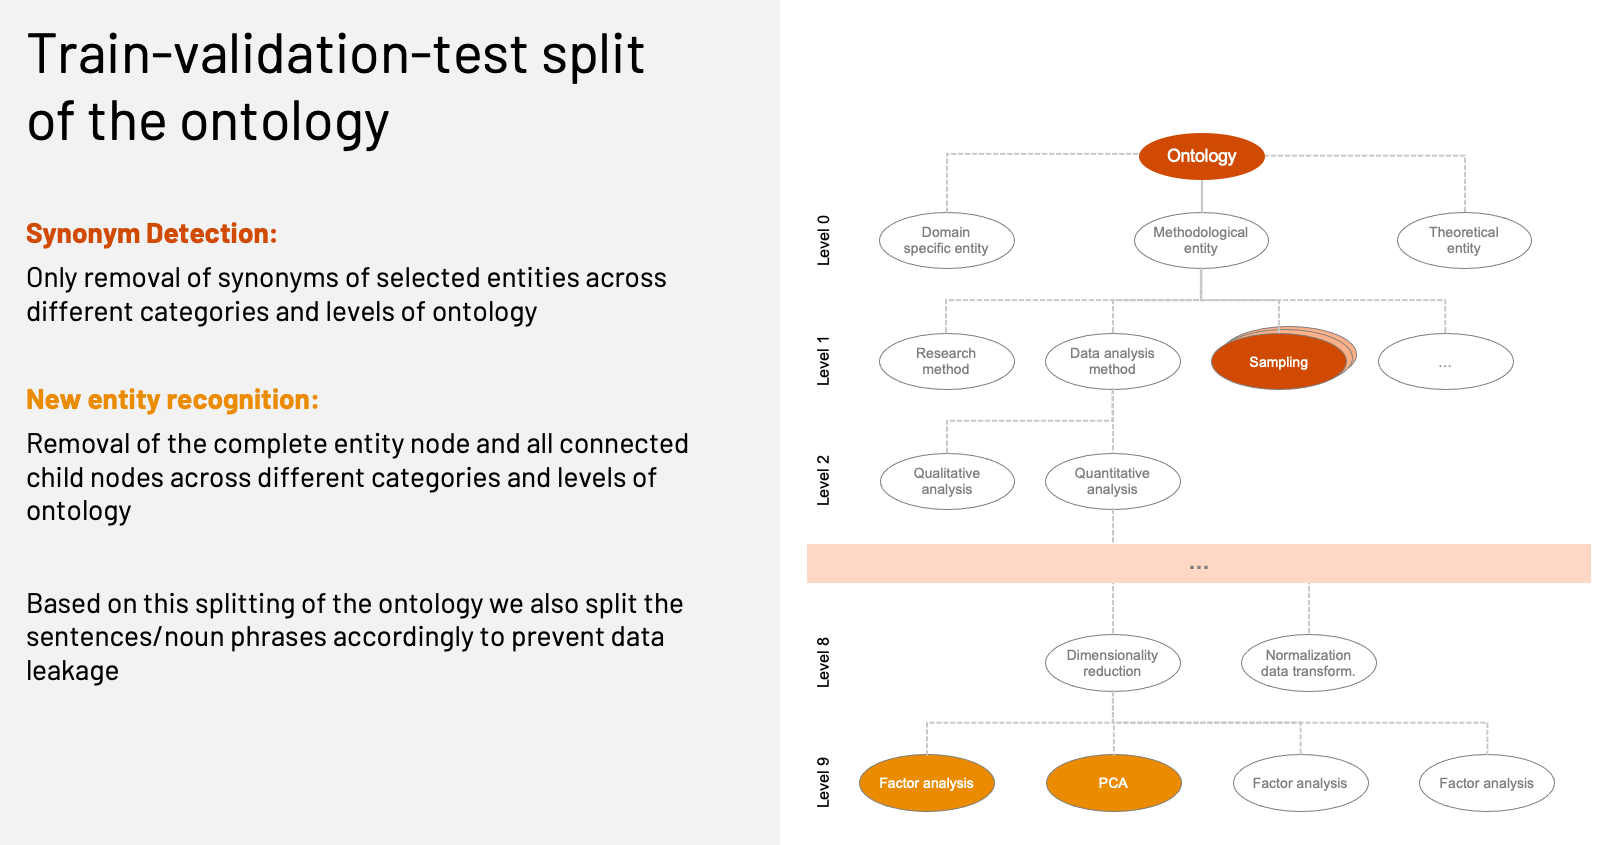

For further details please see notebook: `NOTEBOOK NAME HERE`

#### Select entities for validation and test dataset

- We will remove different nodes across all main topics and levels of the ontology to assess how our model is handling with missing nodes from different "levels"
- To determine which nodes to include we used the `ontology.json` file since here the hierarchy is already visually included, so it was easy to define some random nodes (and child nodes)

**We selcted the following entities as part of the validation/test set:**

|    | level_1                | level_2              | entity_id_to_remove                 |   has_child_nodes |
|---:|:-----------------------|:---------------------|:------------------------------------|------------------:|
|  0 | domain specific entity | IS topic             | business process outsourcing        |                 1 |
|  1 | domain specific entity | IS topic             | cybersecurity behavior              |                 1 |
|  2 | domain specific entity | IS topic             | user interface                      |                 1 |
|  3 | domain specific entity | IS topic             | IT planning                         |                 1 |
|  4 | domain specific entity | IS topic             | business process management         |                 1 |
|  5 | domain specific entity | IS topic             | sharing platform                    |                 1 |
|  6 | domain specific entity | IS topic             | software license                    |                 1 |
|  7 | domain specific entity | IS topic             | IT recruiting                       |                 0 |
|  8 | domain specific entity | IS technology        | enterprise service bus              |                 0 |
|  9 | domain specific entity | IS technology        | online marketing                    |                 1 |
| 10 | domain specific entity | IS technology        | video game                          |                 1 |
| 11 | domain specific entity | IS technology        | optical storage device              |                 1 |
| 12 | domain specific entity | IS technology        | recommender system                  |                 1 |
| 13 | domain specific entity | IS technology        | digital asset management            |                 0 |
| 14 | domain specific entity | IS technology        | high level language                 |                 1 |
| 15 | domain specific entity | Economic sector      | forest industry                     |                 1 |
| 16 | domain specific entity | Economic sector      | hedge fund                          |                 0 |
| 17 | domain specific entity | Economic sector      | structural engineering              |                 1 |
| 18 | domain specific entity | Economic sector      | research institute                  |                 0 |
| 19 | domain specific entity | Economic sector      | private household                   |                 0 |
| 20 | domain specific entity | Economic sector      | plastics industry                   |                 1 |
| 21 | domain specific entity | study object         | group participant                   |                 0 |
| 22 | domain specific entity | study object         | startup                             |                 0 |
| 23 | domain specific entity | study object         | microenterprise                     |                 0 |
| 24 | methodological entity  | research method      | pilot experiment                    |                 0 |
| 25 | methodological entity  | research method      | completely randomized design        |                 0 |
| 26 | methodological entity  | research method      | pilot survey                        |                 0 |
| 27 | methodological entity  | research method      | action research                     |                 1 |
| 28 | methodological entity  | research method      | delphi study                        |                 0 |
| 29 | methodological entity  | research method      | Markov model                        |                 1 |
| 30 | methodological entity  | research method      | database modeling                   |                 1 |
| 31 | methodological entity  | data analysis method | constant comparative analysis       |                 0 |
| 32 | methodological entity  | data analysis method | ensemble learning                   |                 1 |
| 33 | methodological entity  | data analysis method | sentiment analysis                  |                 1 |
| 34 | methodological entity  | data analysis method | autoregressive moving average model |                 0 |
| 35 | methodological entity  | data analysis method | positive correlation                |                 0 |
| 36 | methodological entity  | data analysis method | recurrent neural network            |                 1 |
| 37 | methodological entity  | data analysis method | exploratory factor analysis         |                 0 |
| 38 | methodological entity  | data analysis method | confirmatory factor analysis        |                 0 |
| 39 | methodological entity  | data analysis method | survival function                   |                 1 |
| 40 | methodological entity  | data analysis method | p hacking                           |                 0 |
| 41 | methodological entity  | statistical metric   | Chi square metric                   |                 0 |
| 42 | methodological entity  | statistical metric   | confusion matrix                    |                 0 |
| 43 | methodological entity  | statistical metric   | contingency table                   |                 0 |
| 44 | methodological entity  | validity             | formative validity                  |                 0 |
| 45 | methodological entity  | validity             | criterion validity                  |                 1 |
| 46 | methodological entity  | sampling             | oversampling                        |                 1 |
| 47 | methodological entity  | sampling             | quota sampling                      |                 0 |
| 48 | theoretical entity     | level of analysis    | micro level                         |                 1 |
| 49 | theoretical entity     | level of analysis    | country level                       |                 0 |
| 50 | theoretical entity     | model                | causal model                        |                 0 |
| 51 | theoretical entity     | model                | control variable                    |                 0 |
| 52 | theoretical entity     | model                | taxonomy                            |                 0 |
| 53 | theoretical entity     | model                | theoretical link                    |                 1 |
| 54 | theoretical entity     | model                | control variable                    |                 0 |
| 55 | theoretical entity     | model                | null hypothesis                     |                 0 |
| 56 | theoretical entity     | model                | nomological network                 |                 0 |
| 57 | theoretical entity     | research paradigm    | interpretivism                      |                 0 |
| 58 | theoretical entity     | research paradigm    | realism                             |                 1 |
| 59 | theoretical entity     | theory               | IT security theory                  |                 1 |
| 60 | theoretical entity     | theory               | theory of task technology fit       |                 0 |
| 61 | theoretical entity     | theory               | personality theory                  |                 1 |
| 62 | theoretical entity     | theory               | equity theory                       |                 0 |
| 63 | theoretical entity     | theory               | two-factor theory                   |                 0 |
| 64 | theoretical entity     | theory               | personality theory                  |                 1 |
| 65 | theoretical entity     | theory               | uncanny valley theory               |                 0 |

#### Load preprocessed list of selected entities
- The complete preprocessing steps can be found in the corresponding notebook

In [17]:
# Load final list of removed entities and show results
entities_to_removed = pd.read_csv(data_path_group+"NER/Data_to_split_ontology/NER_ent_to_remove_from_ontology_final.csv", index_col=0)
entities_to_removed.head(1)

,level_1,level_2,entity_id_to_remove,has_child_nodes,lvl_ent,lvl_par_ent,par_ent,ent_list,articles_list,sentences_list,num_ent,num_articles,num_sentences
0,domain specific entity,IS topic,business process outsourcing,1.0,5,4,outsourcing,"['business process outsourcing', 'knowledge pr...","[5414, 5218, 440, 5609, 5610, 5611, 1195, 2659...","['5414_1618_1639', '5218_4403_4488', '440_8401...",3,130,351


In [18]:
# Lets check the distributiton of the selcted entities accross the ontology
entities_to_removed.groupby(["level_1", "level_2", "lvl_ent"]).aggregate({'num_ent' :["sum"], "entity_id_to_remove":["count"]})

num_ent  \
                                                        sum   
level_1                level_2              lvl_ent           
domain specific entity Economic sector      3             1   
                                            4            10   
                                            5             2   
                       IS technology        4            16   
                                            5            12   
                                            7             4   
                       IS topic             3            10   
                                            4            10   
                                            5             9   
                                            6             6   
                       study object         4             2   
                                            5             1   
methodological entity  data analysis method 4             1   
                                            5             6   
                                            6             1   
                                            7             3   
                                            8             8   
                                            9             2   
                       research method      5             3   
                                            6            11   
                                            7             2   
                       sampling             4             3   
                       statistical metric   3             2   
                                            4             1   
                       validity             4             1   
                                            5             3   
theoretical entity     level of analysis    3             3   
                                            4             1   
                       model                3             2   
                                            4             1   
                                            5             4   
                                            6             1   
                       research paradigm    3             2   
                                            4             1   
                       theory               4            10   
                                            5             1   

                                                    entity_id_to_remove  
                                                                  count  
level_1                level_2              lvl_ent                      
domain specific entity Economic sector      3                         1  
                                            4                         3  
                                            5                         2  
                       IS technology        4                         2  
                                            5                         4  
                                            7                         1  
                       IS topic             3                         1  
                                            4                         3  
                                            5                         3  
                                            6                         1  
                       study object         4                         2  
                                            5                         1  
methodological entity  data analysis method 4                         1  
                                            5                         3  
                                            6                         1  
                                            7                         3  
                                            8                         1  
                                            9                         1  
                       research method  

#### Split the ontology

- We then used the preprocessed list to then split the ontology accordingly into train, validation and test set
- Since we try to compute a similarity score between the existing entities/ synonyms and the noun phrases of the sentences, we need two different lists for each of our train, val and test dataset: 
  1. List of the entites and synoynms
  2. List of noun phrases per sentence 

In [19]:
# Load split noun phrases and ontology and display results
NER_entities_train = pd.read_csv(data_path_group+"NER/NER_entities_train.csv", index_col=0)
#NER_entities_val = pd.read_csv(data_path_group+"NER/NER_entities_val.csv", index_col=0)
#NER_entities_test = pd.read_csv(data_path_group+"NER/NER_entities_test.csv", index_col=0)

In [20]:
NER_entities_train.head(1)

,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
0,188,188_3753_3772,videotex,which,0


In [21]:
NER_entities_train.shape

(13172377, 5)

In [22]:
# Load split ontology and display results
#NER_ontology_train = pd.read_csv(data_path_group+"NER/NER_ontology_train.csv", index_col=0)
#NER_ontology_val = pd.read_csv(data_path_group+"NER/NER_ontology_val.csv", index_col=0)
NER_ontology_test = pd.read_csv(data_path_group+"NER/NER_ontology_test.csv", index_col=0)

In [23]:
NER_ontology_test.shape

(5205, 4)

### Model selection

- Next to creating the different datasets and splits we also needed to decide which model we will fine tune. 
- Within this project we tested multiple models on a sample article on the ontology and evaluated their OOB performance on synonym detection.
- We considered the following pre-trained models:
  - **Glove**
  - **Averaged Word2Vec model** (word mover's distance)
  - **BERT transformer**
  - **Sentence transformer** (all-MiniLM-L6-v2)
- Due to time and resource limitations we only continued finetuning the best of these models 

For further details please see notebooks: `NOTEBOOK NAME HERE`

#### Evaluation dataset (sample article)

In [24]:
# Function to bin data


#### Model performacne on sample article

##### Glove

##### Word2Vec model (word mover's distance)

In [25]:
# Load results
wmd_scores = pd.read_csv(data_path_group+"WMD_similarity_scores_sample_article.csv", index_col=0)

##### BERT transformer

##### Sentence transformer


## Finetuning the models

Although the fine-tuning procedure is the same for both tasks, we had 2 different sets of train-test-evaluation for each of the task and therefore, would still like to split this section according to the tasks and show you the results. 

### Finetuning for synonym detection task

#### Synonym Dataset


Parameters: 
*   `batch_size` = 128
*   `num_epochs` = 4


*   Evaluation function: `BinaryClassificationEvaluator()`


Results: 99.9% on evaluation samples (Baseline model: 84%)





For further details, please see notebooks: `TE_fine_tuning_SBert_SynDet_df.ipynb`

#### Triplet Dataset

Parameters: 
*   `batch_size` = 32
*   `num_epochs` = 2


*   Evaluation function: `TripletEvaluator()`


Results: 94.96% on evaluation samples

For further details, please see notebooks: `JE_sentence_trasnformers_TripletsDataset.ipynb`




### Finetuning for new entity recognition task

#### Synonym Dataset

Parameters: 
*   `batch_size` = 64
*   `num_epochs` = 1


*   Evaluation function: `BinaryClassificationEvaluator()`


Results: 99.86% on evaluation samples (Baseline model: 90.78%)

For further details, please see notebooks: `PH_NER_FineTune_ST.ipynb`

#### Triplet Dataset

Parameters: 
*   `batch_size` = 32
*   `num_epochs` = 1


*   Evaluation function: `TripletEvaluator()`


Results: 85.47% on evaluation samples (Baseline model: 95.30%)

For further details, please see notebooks: `PH_NER_FineTune_ST.ipynb`

### Compare model performance on training sets

#### Synonym detection

#### New Entity Recognition 

## Evaluate model performance on actual task


We use both of the fine-tuned as well as the "vanilla" Sentence Transformer models (for a clear comparison) to do the 2 tasks assigned to our group, which are: 

*   Detecting synonyms of existent entities
*   Recognizing new entities 

to see the accuracy of each model.


### Synonym Detection

The idea is as follows:

*   Embedding the noun phrases and the synonyms of the entities

*   Computing the cosine similarity of the noun phrase with each of the synonyms of every entity
*   Returning 1 match with the **highest** cosine similarity that is **not 1** (since cosine similarity equal to 1 means that the words are basically the same) 


*   Comparing our prediction with the actual entity labeled in the ontology to see if our match is correct or not

Further details can be found in this notebook: `MA_PerformanceEvaluation_SynDet.ipynb`


The results: 

1. **"Vanilla" Sentence Transformer (without any fine-tuning)**

Overall Accuracy: 12.38%


In [35]:
SynDet_results_vanilla = pd.read_csv(data_path_group+"SynDet/SynDet_results_vanilla")
SynDet_results_vanilla

,score,total,no_correct,pct_correct_in_bin
0,"(0.9, 1.0]",409,318,0.78
1,"(0.8, 0.9]",934,318,0.34
2,"(0.7, 0.8]",1869,372,0.20
3,"(0.6, 0.7]",2448,291,0.12
4,"(0.5, 0.6]",2904,122,0.04
5,"(0.4, 0.5]",2824,44,0.02
6,"(0.3, 0.4]",492,7,0.01
7,"(0.2, 0.3]",6,0,0.00
8,"(0.1, 0.2]",0,0,NaN
9,"(0.0, 0.1]",0,0,NaN


2. **Sentence Transformer fine-tuned on the Synonym Dataset**

Overall Accuracy: 9.74%


In [36]:
SynDet_results_syndataset = pd.read_csv(data_path_group+"SynDet/SynDet_results_syndataset")
SynDet_results_syndataset

,score,total,no_correct,pct_correct_in_bin
0,"(0.9, 1.0]",3418,728,0.21
1,"(0.8, 0.9]",1826,221,0.12
2,"(0.7, 0.8]",1593,88,0.06
3,"(0.6, 0.7]",1787,71,0.04
4,"(0.5, 0.6]",1243,28,0.02
5,"(0.4, 0.5]",1244,21,0.02
6,"(0.3, 0.4]",622,0,0.00
7,"(0.2, 0.3]",141,0,0.00
8,"(0.1, 0.2]",0,0,NaN
9,"(0.0, 0.1]",0,0,NaN


3. **Sentence Transformer fine-tuned on the Triplet Dataset**

Overall Accuracy: 12.25%


In [37]:
SynDet_results_tripldataset = pd.read_csv(data_path_group+"SynDet/SynDet_results_tripldataset")
SynDet_results_tripldataset

,score,total,no_correct,pct_correct_in_bin
0,"(0.9, 1.0]",395,300,0.76
1,"(0.8, 0.9]",951,330,0.35
2,"(0.7, 0.8]",1858,364,0.20
3,"(0.6, 0.7]",2448,287,0.12
4,"(0.5, 0.6]",2904,123,0.04
5,"(0.4, 0.5]",2823,44,0.02
6,"(0.3, 0.4]",488,7,0.01
7,"(0.2, 0.3]",5,0,0.00
8,"(0.1, 0.2]",0,0,NaN
9,"(0.0, 0.1]",0,0,NaN


Conclusion: 


*    The vanilla model without any fine-tuning actually gave back the most correct matches. 
*   The model fine-tuned on the Triplet Dataset did quite similar to the vanilla one, which means that the fine-tuning was not much in effect.

*   Fine-tuning on the synonym dataset actually changed the scenario, where the embedding are changed significantly and the model returned much more matches within the 1st range. Despite the higher number of correct matches, the accuracy is not that great

We should just take the vanilla ST or create better datasets to fine-tune the model. 

We advise to just take the 1st bin as results to give back to the user to revise, since the number of matches are still very high when going down to the other bins but the accuracy is considerably decreasing.






### New Entity Recognition

The Idea: 


*   Removing certain entities from the ontology
*   Creating embeddings for all noun phrases, but only create embeddings from the rest entities 

*   Returning one entity for each noun phrase, which has the highest cosine similarity
*   Matching the results we get with the **parent entity** in the ontology 









For further details please see notebook: `PH_NER_Evaluate_Model_Performance.ipynb`

The Results

1. **Vanilla Sentence Transformer without any fine-tuning**

Overall Accuracy: 9%

In [29]:
sim_scores_vanilla_final = pd.read_csv(data_path_group+"NER/similarities_test_vanilla_final.csv")
sim_scores_syn_final = pd.read_csv(data_path_group+"NER/similarities_test_syn_final.csv")
sim_scores_trip_final = pd.read_csv(data_path_group+"NER/similarities_test_trip_final.csv")

In [30]:
def create_grouped_bins(sim_scores_final):
  
  # Create bins of similarity score to check the number of correct matches compared to the labels of the database
  grouped_df = sim_scores_final.groupby(pd.cut(sim_scores_final.score, np.arange(0.,1.1,0.1)))[["correct_match_parent"]]
  corr_match_bins = np.round(grouped_df.sum()/grouped_df.count(),2).rename(columns={"correct_match_parent":"pct_correct_in_bin"})
  corr_match_bins["no_correct"]= grouped_df.sum()
  corr_match_bins["total"]= grouped_df.count()
  corr_match_bins = corr_match_bins[["total", "no_correct", "pct_correct_in_bin"]]
  corr_match_bins = corr_match_bins.iloc[::-1] #reverse order

  return corr_match_bins

In [31]:
corr_match_bins_vanilla = create_grouped_bins(sim_scores_vanilla_final)
corr_match_bins_syn = create_grouped_bins(sim_scores_syn_final)
corr_match_bins_trip = create_grouped_bins(sim_scores_trip_final)

In [32]:
corr_match_bins_vanilla.append(corr_match_bins_vanilla.sum().rename('Total'))

,total,no_correct,pct_correct_in_bin
score,,,
"(0.9, 1.0]",9.0,0.0,0.00
"(0.8, 0.9]",8.0,2.0,0.25
"(0.7, 0.8]",34.0,5.0,0.15
"(0.6, 0.7]",17.0,0.0,0.00
"(0.5, 0.6]",11.0,0.0,0.00
"(0.4, 0.5]",2.0,0.0,0.00
"(0.3, 0.4]",0.0,0.0,NaN
"(0.2, 0.3]",0.0,0.0,NaN
"(0.1, 0.2]",0.0,0.0,NaN


2. **Sentence Transformer fine-tuned on the Synonym Dataset**

Overall Accuracy: 0%

In [33]:
corr_match_bins_syn.append(corr_match_bins_syn.sum().rename('Total'))

,total,no_correct,pct_correct_in_bin
score,,,
"(0.9, 1.0]",26.0,0.0,0.0
"(0.8, 0.9]",10.0,0.0,0.0
"(0.7, 0.8]",11.0,0.0,0.0
"(0.6, 0.7]",18.0,0.0,0.0
"(0.5, 0.6]",6.0,0.0,0.0
"(0.4, 0.5]",5.0,0.0,0.0
"(0.3, 0.4]",4.0,0.0,0.0
"(0.2, 0.3]",0.0,0.0,NaN
"(0.1, 0.2]",0.0,0.0,NaN


3. **Sentence Transformer fine-tuned on the Triplet Dataset**

Overall Accuracy: 2%

In [34]:
corr_match_bins_trip.append(corr_match_bins_trip.sum().rename('Total'))

,total,no_correct,pct_correct_in_bin
score,,,
"(0.9, 1.0]",24.0,2.0,0.08
"(0.8, 0.9]",27.0,0.0,0.00
"(0.7, 0.8]",16.0,0.0,0.00
"(0.6, 0.7]",8.0,0.0,0.00
"(0.5, 0.6]",4.0,0.0,0.00
"(0.4, 0.5]",2.0,0.0,0.00
"(0.3, 0.4]",0.0,0.0,NaN
"(0.2, 0.3]",0.0,0.0,NaN
"(0.1, 0.2]",0.0,0.0,NaN


Conclusion: 

*   The "vanilla" again did the best where the most correct matches fall within the 2nd or 3rd bin range. This makes sense, since parent entity should be too similar, but more a generic umbrella term of its child. 
*   Fine-tuning on the Synonym Dataset made the model worse, as it could not identify any correct match

We could not manage any promising outcome regarding the task of recognizing new entity and would propose some recommendations how to approach the problem differently in the outlook part



## Recommendations & Outlook



1.   The way we did the project was to split up the tasks and divide them among us, so if the project was to be taken over and to be worked on further in the future, there should be proper **pipeline set up for the process** so it is clearer what has to be done within the workflow
2.   The entities were labeled based on the sentence and it would be more accurate and improve comparability if **the position of the sentence**, where the entity was tagged, is also **specified**
3. Suggestions for further training/modelling:


*   **Finetuning the dataset based on sentences** instead, as the fine-tuning process on our split dataset didnt yield optimistic result for us
*   **For the task of detecting synonym, training a neural network classifier**, where the output would be the already existing entities in the ontology and have the model predict which target would be the most likely

*   **Turning the ontology into graph data and train model on distance loss**, meaning that more importance would be emphasized on the parent entity and any entity that is a couple of levels further away should be penalized just as much as an entity that is completely far away in the graph 
*   Training the model further by **having the user giving us feedback**. For example, when they are shown with option that could be new synonym or new entity, they could either accept it or deny it as entry. And the model should avoid suggesting the denied option again in the next prediction. 







